# Latent GP with Negative Binomial likelihood

Using PyMC3's Latent Gaussian Process implementation
- API: https://docs.pymc.io/api/gp/implementations.html
- Example: https://docs.pymc.io/notebooks/GP-Latent.html

## Goal
Given a series of past daily counts (admissions, census, etc.) $$y_1, y_2, ..., y_T$$

Assuming $T$ is today, want to predict counts $$y_{T+1}, y_{T+2}, ..., y_{T+F}$$ for $F$ days ahead.

## Model

Suppose that $y$ is Negative Binomial distributed over the exponential of a latent Gaussian Process, i.e.,
$$y_t \sim \text{NegBin}(\mu = \text{exp}(f_t), \alpha)$$

where $f$ is modeled by a Gaussian Process
$$ f_t \sim N(m(t), k(t,t'))$$
with constant mean
$$m(t) = c$$
and squared exponential covariance
$$k(t,t') = a^2 \exp\left(-\frac{(t-t')^2}{2l^2}\right)$$

## Parameters and their Priors

GP mean: $$c \sim \text{TruncatedNormal}(\mu_c, 5, \text{low}=0)$$
SqExp cov amplitude: $$a \sim \text{TruncatedNormal}(\mu_a, 5, \text{low}=0)$$
SqExp cov time-scale: $$l \sim \text{TruncatedNormal}(\mu_l, 5, \text{low}=0)$$
Negative Binomial dispersion parameter: $$\alpha \sim \text{TruncatedNormal}(\mu_\alpha, 500, \text{low}=0)$$

## Hyperparameters

## Training

Let's use the subscript "past" to refer to indices $1$ through $T$, and the subscript "future" for indices $T+1$ through $T+F$.

1. Specify a Latent GP with the mean and covariance functions defined above.
1. Define a `prior` distribution over all $f$ (i.e., condition on both $t_\text{past}$ and $t_\text{future}$).
1. Define the observed variable $$y_\text{past} \sim \text{NegBin}(\mu = \exp(f_\text{past}), \alpha)$$ Set `mu` to be the exponential of the first $T$ $f$ values, i.e., only $f_\text{past}$.
1. Use PyMC3's MCMC to draw samples from the posterior $$c^s, a^s, l^s, \alpha^s, f^s \sim p(c, a, l, \alpha, f_\text{past}, f_\text{future} | y_\text{past})$$

In [25]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import theano
import theano.tensor as tt
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"

In [26]:
train_df = pd.read_csv('../Middlesex.csv')
y = train_df['cases'].values.astype(float)
T = len(y)
F = 7
t = np.arange(T+F)[:,None]

In [27]:
with pm.Model() as model:
    c = pm.TruncatedNormal('mean', mu=5, sigma=5, lower=0)
    mean_func = pm.gp.mean.Constant(c=c)
    
    a = pm.TruncatedNormal('amplitude', mu=5, sigma=5, lower=0)
    l = pm.TruncatedNormal('time-scale', mu=10, sigma=5, lower=0)
    cov_func = a**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=l)
    
    gp = pm.gp.Latent(mean_func=mean_func, cov_func=cov_func)
    
    f = gp.prior('f', X=t)
    
    alpha = pm.TruncatedNormal('alpha', mu=2000, sigma=500, lower=0)
    y_past = pm.NegativeBinomial('y_past', mu=tt.exp(f[:T]), alpha=alpha, observed=y)

In [28]:
with model:
    trace = pm.sample(500, tune=1000, chains=1, target_accept=.98, max_treedepth=15, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [alpha, f_rotated_, time-scale, amplitude, mean]
Sampling chain 0, 0 divergences: 100%|██████████| 1500/1500 [1:21:34<00:00,  3.26s/it]   
Only one chain was sampled, this makes it impossible to run some convergence checks


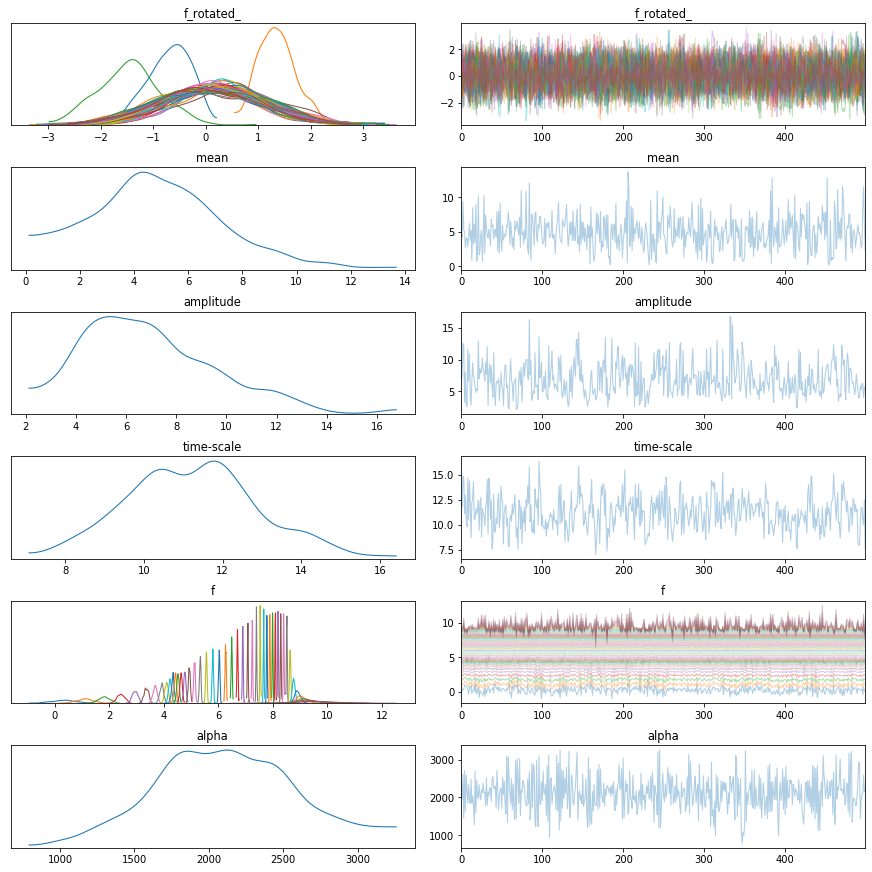

In [29]:
pm.traceplot(trace);

## Forecasting Procedure

<!-- 1. Define a predictive distribution for future $f$ values $$p(f_\text{future} | f_\text{past})$$ using PyMC3's Latent GP `conditional` method. -->
1. Define a predictive distribution for future $y$ values $$y_\text{future} \sim \text{NegBin}(\mu = \exp(f_\text{future}), \alpha)$$
1. Use PyMC3's `sample_posterior_predictive` and the posterior samples collected during training to produce forecasts.

In [30]:
n_samples = 1000

with model:
    y_future = pm.NegativeBinomial('y_future', mu=tt.exp(f[-F:]), alpha=alpha, shape=(F,))
    forecasts = pm.sample_posterior_predictive(trace, vars=[y_future], samples=n_samples, random_seed=42)

samples = forecasts['y_future']

100%|██████████| 1000/1000 [00:01<00:00, 876.66it/s]


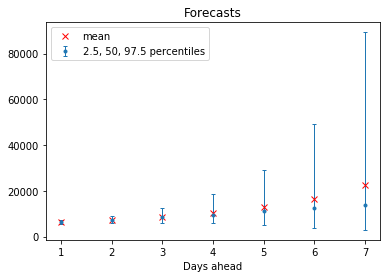

In [33]:
low = np.zeros(F)
high = np.zeros(F)
mean = np.zeros(F)
median = np.zeros(F)

for i in range(F):
    low[i] = np.percentile(samples[:,i], 2.5)
    high[i] = np.percentile(samples[:,i], 97.5)
    median[i] = np.percentile(samples[:,i], 50)
    mean[i] = np.mean(samples[:,i])

xticks = np.arange(1,F+1)
plt.errorbar(xticks, median,
             yerr=[median-low, high-median],
             capsize=2, fmt='.', linewidth=1,
             label='2.5, 50, 97.5 percentiles');
plt.plot(xticks, mean, 'rx', label='mean');
plt.legend();
plt.title('Forecasts');
plt.xlabel('Days ahead');

## Heldout Scoring Procedure

1. Partition the data to treat the first 80% as "past" and the last 20% as "future." We'll use $y_\text{past}$ as the training set, and $y_\text{future}$ as the validation set.
1. Train the model using $y_\text{past}$.
<!-- 1. Define a predictive distribution for future $f$ values $$p(f_\text{future} | f_\text{past})$$ using PyMC3's Latent GP `conditional` method. -->
<!-- 1. Use PyMC3's `sample_posterior_predictive` to draw one sample of $f_\text{future}$ for each posterior sample collected during training. -->
<!-- 1. Compute the log probability of the observed $y_\text{future}$ using Monte Carlo estimation: $$\log p(y_\text{future} | y_\text{past}) = \log \frac{1}{S} \sum_{s=1}^S p(y_\text{future} | f^s, c^s, a^s, l^s, \alpha^s, y_\text{past})$$ where {$f^s, c^s, a^s, l^s, \alpha^s$} are samples drawn from the posterior, $S$ is the total number of samples, and $$p(y_\text{future} | f^s, c^s, a^s, l^s, \alpha^s, y_\text{past}) = \text{NegBin}(\mu = \exp(f_\text{future}^s), \alpha=\alpha^s)$$ -->
1. Define the predictive distribution $$y_\text{future} \sim \text{NegBin}(\mu = \exp(f_\text{future}), \alpha)$$ Set `observed` to be the observed $y_\text{future}$ values.
1. For each posterior sample {$f^s, c^s, a^s, l^s, \alpha^s$}, compute the log probability of the observed $y_\text{future}$. Then use Monte Carlo integration: $$\log p(y_\text{future} | y_\text{past}) = \log \frac{1}{S} \sum_{s=1}^S p(y_\text{future} | f^s, c^s, a^s, l^s, \alpha^s, y_\text{past})$$

In [34]:
df = pd.read_csv('../Middlesex.csv')
y = df['cases'].astype(float)

T = int(.8 * len(y))
y_tr = y[:T]
y_va = y[T:]
F = len(y_va)

t = np.arange(T+F)[:,None]

In [35]:
with pm.Model() as model:
    c = pm.TruncatedNormal('mean', mu=5, sigma=5, lower=0)
    mean_func = pm.gp.mean.Constant(c=c)
    
    a = pm.TruncatedNormal('amplitude', mu=5, sigma=5, lower=0)
    l = pm.TruncatedNormal('time-scale', mu=10, sigma=5, lower=0)
    cov_func = a**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=l)
    
    gp = pm.gp.Latent(mean_func=mean_func, cov_func=cov_func)
    
    f = gp.prior('f', X=t)
    
    alpha = pm.TruncatedNormal('alpha', mu=2000, sigma=500, lower=0)
    y_past = pm.NegativeBinomial('y_past', mu=tt.exp(f[:T]), alpha=alpha, observed=y_tr)

In [36]:
with model:
    trace = pm.sample(500, tune=1000, chains=1, target_accept=.98, max_treedepth=15, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/allylee/miniconda3/envs/spr_2020s_env/lib/python3.8/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Sequential sampling (1 chains in 1 job)
NUTS: [alpha, f_rotated_, time-scale, amplitude, mean]
Sampling chain 0, 0 divergences: 100%|██████████| 1500/1500 [38:30<00:00,  1.54s/it] 
Only one chain was sampled, this makes it impossible to run some convergence checks


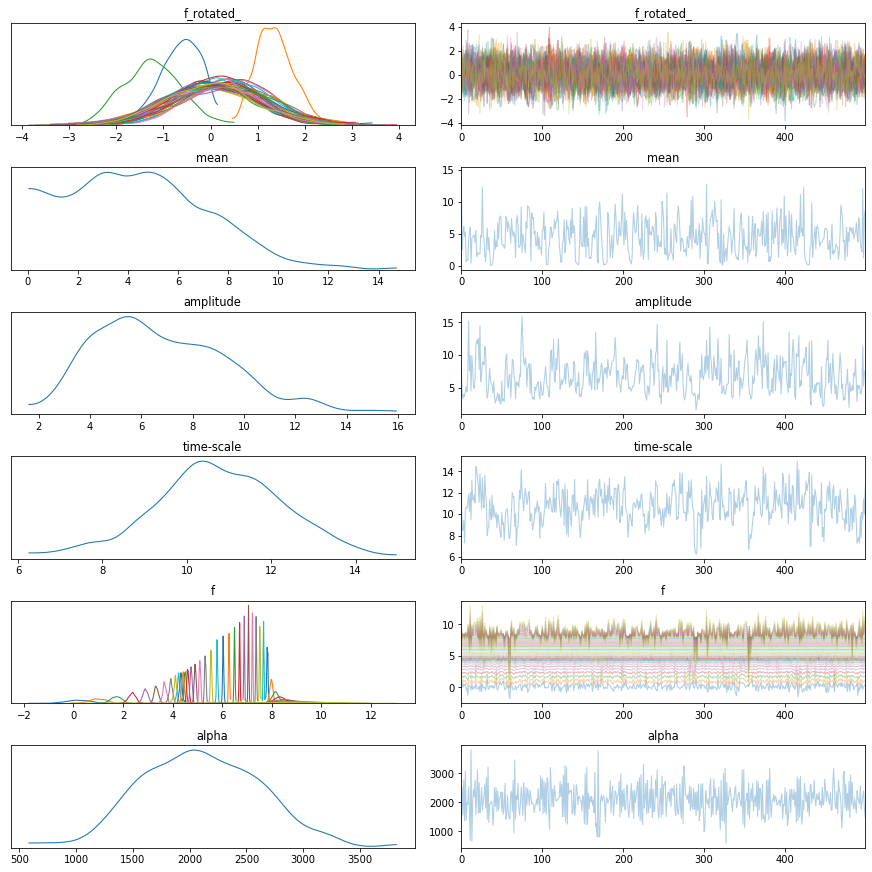

In [37]:
pm.traceplot(trace);

In [38]:
with model:
    y_future = pm.NegativeBinomial('y_future', mu=tt.exp(f[-F:]), alpha=alpha, observed=y_va)

In [39]:
logp_list = np.zeros(len(trace))

for i in range(len(trace)):
    if i % 100 == 0:
        print(f'Scored {i} samples...')
        
    logp_list[i] = y_future.logp(trace[i])

Scored 0 samples...
Scored 100 samples...
Scored 200 samples...
Scored 300 samples...
Scored 400 samples...


In [40]:
score = np.log(np.mean(np.exp(logp_list))) / F
print(f'Heldout log likelihood = {score}')

Heldout log likelihood = -7.24276389970127
